🤖 Data Loaded, Scaled, and Split.
----------------------------------------------------------------------
### A1. Feature Correlation Analysis and Heatmap ###
✅ Correlation Matrix Calculated.


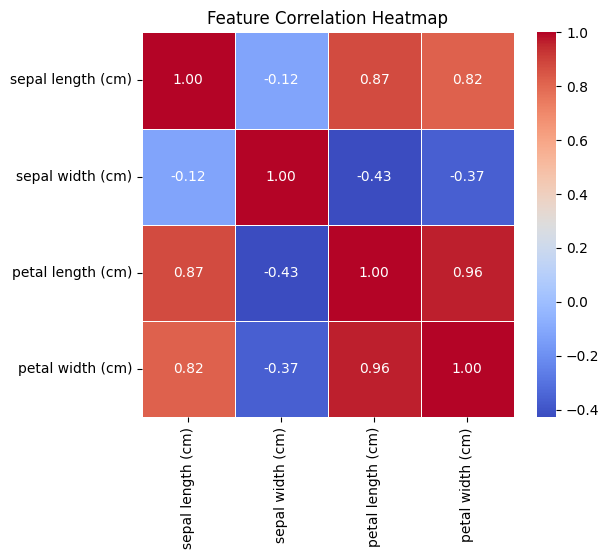

c:\Users\nikhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nikhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nikhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nikhi\AppData\Local\Programs\Python\P

----------------------------------------------------------------------
### A2 & A3. PCA for Feature Reduction and Classification ###
✅ PCA (99% Variance): Components retained = **3**
Model Accuracy with 3 components: **0.9111**
✅ PCA (95% Variance): Components retained = **2**
Model Accuracy with 2 components: **0.8889**
Baseline Accuracy (4 features, No Reduction): **0.9111**
----------------------------------------------------------------------
### A4. Sequential Feature Selection (SFS) ###
✅ SFS (Forward, n=2): Selected Features = **['sepal width (cm)', 'petal width (cm)']**
Model Accuracy with SFS features: **0.8667**

[Table of Model Performance Comparison]
| Method                   |   Features/Components |   Accuracy |
|:-------------------------|----------------------:|-----------:|
| Baseline (Full Features) |                     4 |     0.9111 |
| PCA (3 Components)       |                     3 |     0.9111 |
| PCA (2 Components)       |                     2 |     0.8889 |

100%|██████████| 1/1 [00:00<00:00, 151.95it/s]

🔬 LIME Explanation (Instance 10, Predicted: setosa)
Features contributing to the prediction (setosa):
   - petal width (cm) <= 0.30: 0.6462
   - sepal width (cm) > 3.30: 0.1703

💡 SHAP Explanation (Instance 10, Predicted: setosa)
Feature | SHAP Value (Contribution to Prediction)
---|---
sepal width (cm) | 0.1491
petal width (cm) | -0.1731
----------------------------------------------------------------------


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
import lime
import lime.lime_tabular
import shap
import warnings

# Set a random state for reproducibility
RANDOM_STATE = 42

def load_and_preprocess_data():
    """
    Loads the Iris dataset, converts it to a DataFrame, and splits it.
    """
    iris = load_iris()
    X_df = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target
    feature_names = iris.feature_names

    # Split data (use raw data to compare transformations later)
    X_train_raw_df, X_test_raw_df, y_train, y_test = train_test_split(
        X_df, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )

    # Scale the data for PCA and some models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw_df)
    X_test_scaled = scaler.transform(X_test_raw_df)
    
    # Return numpy arrays for models, but keep DF for A1
    return X_df, y, X_train_scaled, X_test_scaled, X_train_raw_df.values, X_test_raw_df.values, y_train, y_test, feature_names, iris.target_names

# --- A1. Feature Correlation Analysis and Heatmap ---
def calculate_correlation_matrix(X_df):
    """
    Performs feature correlation analysis.
    """
    correlation_matrix = X_df.corr()
    return correlation_matrix

# --- A2 & A3. PCA for Feature Reduction ---
def perform_pca_and_classify(X_train_scaled, X_test_scaled, y_train, y_test, explained_variance_ratio):
    """
    Performs PCA to retain a specified percentage of explained variance (A2/A3) 
    and classifies the data.
    """
    pca = PCA(n_components=explained_variance_ratio, random_state=RANDOM_STATE)
    
    # Fit PCA on training data and transform both sets
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    n_components = pca.n_components_
    
    model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=200, random_state=RANDOM_STATE)
    
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, n_components, model

# --- A4. Sequential Feature Selection (SFS) ---
def perform_sfs_and_classify(X_train_raw, X_test_raw, y_train, y_test):
    """
    Performs Sequential Feature Selection (SFS) (A4) and classifies the data.
    """
    estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
    
    sfs = SequentialFeatureSelector(
        estimator, 
        n_features_to_select=2, 
        direction='forward', 
        cv=3, 
        n_jobs=-1
    )
    
    sfs.fit(X_train_raw, y_train)
    
    X_train_sfs = sfs.transform(X_train_raw)
    X_test_sfs = sfs.transform(X_test_raw)
    
    model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=200, random_state=RANDOM_STATE)
    model.fit(X_train_sfs, y_train)
    y_pred = model.predict(X_test_sfs)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, sfs.get_support(indices=True), model

# --- A5. LIME and SHAP Explanation ---
# <-- FIX: Function signature is simplified. It now accepts the *actual data*
# and *feature names* that the SFS model was trained on.
def explain_model_with_xai(model, X_train_sfs, instance_to_explain, sfs_feature_names, class_names):
    """
    Uses LIME and SHAP to explain a single prediction (A5).
    
    Args:
        model (estimator): The final trained SFS model.
        X_train_sfs (np.array): The SFS-transformed training data (background data).
        instance_to_explain (np.array): The 1D SFS-transformed instance to explain.
        sfs_feature_names (list): The names of the SFS-selected features.
        class_names (list): Target class names.

    Returns:
        tuple: (LIME_explanation, SHAP_explanation)
    """
    
    # --- LIME Explanation ---
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_sfs, # <-- FIX: Use SFS training data
        feature_names=sfs_feature_names, # <-- FIX: Use SFS feature names
        class_names=class_names,
        mode='classification',
        random_state=RANDOM_STATE
    )
    
    lime_exp = lime_explainer.explain_instance(
        data_row=instance_to_explain, # <-- FIX: Use the 1D SFS instance
        predict_fn=model.predict_proba,
        num_features=len(sfs_feature_names),
        top_labels=1
    )

    # --- SHAP Explanation (KernelExplainer for model-agnostic explanation) ---
    # Suppress warnings from SHAP (often related to sample size)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # <-- FIX: Use SFS training data as background
        shap_explainer = shap.KernelExplainer(model.predict_proba, X_train_sfs)
        
        # <-- FIX: Reshape the 1D instance to 2D (1, n_features) for shap_values
        shap_values = shap_explainer.shap_values(instance_to_explain.reshape(1, -1))
    
    return lime_exp, shap_values

# --- Main Program Execution ---
if __name__ == '__main__':
    # <-- FIX: Cleaned up variable names from the data loader
    X_df, _, X_train_scaled, X_test_scaled, X_train_raw, X_test_raw, y_train, y_test, feature_names, class_names = load_and_preprocess_data()
    print("🤖 Data Loaded, Scaled, and Split.")
    print("-" * 70)

    # --- A1. Feature Correlation Analysis and Heatmap ---
    print("### A1. Feature Correlation Analysis and Heatmap ###")
    corr_matrix = calculate_correlation_matrix(X_df)
    print("✅ Correlation Matrix Calculated.")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()

    print("-" * 70)
    
    # --- A2 & A3. PCA Experiments ---
    print("### A2 & A3. PCA for Feature Reduction and Classification ###")
    
    # <-- FIX: Pass the SCALED data to the PCA function
    acc_99, n_comp_99, _ = perform_pca_and_classify(X_train_scaled, X_test_scaled, y_train, y_test, 0.99)
    print(f"✅ PCA (99% Variance): Components retained = **{n_comp_99}**")
    print(f"Model Accuracy with {n_comp_99} components: **{acc_99:.4f}**")
    
    # <-- FIX: Pass the SCALED data to the PCA function
    acc_95, n_comp_95, _ = perform_pca_and_classify(X_train_scaled, X_test_scaled, y_train, y_test, 0.95)
    print(f"✅ PCA (95% Variance): Components retained = **{n_comp_95}**")
    print(f"Model Accuracy with {n_comp_95} components: **{acc_95:.4f}**")

    # --- Comparison with a Baseline Model (No Feature Reduction) ---
    baseline_model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=200, random_state=RANDOM_STATE)
    baseline_model.fit(X_train_scaled, y_train) # Use scaled data
    baseline_acc = accuracy_score(y_test, baseline_model.predict(X_test_scaled))
    print(f"Baseline Accuracy (4 features, No Reduction): **{baseline_acc:.4f}**")
    print("-" * 70)
    
    # --- A4. Sequential Feature Selection (SFS) ---
    print("### A4. Sequential Feature Selection (SFS) ###")
    
    sfs_acc, sfs_indices, sfs_model = perform_sfs_and_classify(X_train_raw, X_test_raw, y_train, y_test)
    selected_feature_names = [feature_names[i] for i in sfs_indices]
    
    print(f"✅ SFS (Forward, n=2): Selected Features = **{selected_feature_names}**")
    print(f"Model Accuracy with SFS features: **{sfs_acc:.4f}**")

    # Final Tabulated Results for Report
    results_table = pd.DataFrame({
        'Method': ['Baseline (Full Features)', f'PCA ({n_comp_99} Components)', f'PCA ({n_comp_95} Components)', 'SFS (2 Features)'],
        'Features/Components': [len(feature_names), n_comp_99, n_comp_95, len(sfs_indices)],
        'Accuracy': [baseline_acc, acc_99, acc_95, sfs_acc]
    })
    print("\n[Table of Model Performance Comparison]")
    try:
        print(results_table.to_markdown(index=False, floatfmt=".4f"))
    except ImportError:
        print("Install 'tabulate' (pip install tabulate) for a formatted table.")
        print(results_table)
    print("-" * 70)

    # --- A5. LIME and SHAP Explanation ---
    print("### A5. LIME and SHAP Explanation ###")
    
    # <-- FIX: Create the SFS-transformed data ONCE using the correct indices
    X_train_sfs = X_train_raw[:, sfs_indices]
    X_test_sfs = X_test_raw[:, sfs_indices]
    
    instance_idx = 10 
    # <-- FIX: Select the 1D SFS-transformed instance
    instance_to_explain_sfs = X_test_sfs[instance_idx] 
    
    # <-- FIX: Call the updated, cleaner explanation function
    lime_exp, shap_vals = explain_model_with_xai(
        sfs_model, 
        X_train_sfs, 
        instance_to_explain_sfs, 
        selected_feature_names, # Pass the correct feature names
        class_names
    )
    
    # Predicted class for the instance
    predicted_class = sfs_model.predict(instance_to_explain_sfs.reshape(1, -1))[0]
    predicted_class_name = class_names[predicted_class]
    
    # LIME Output
    print(f"🔬 LIME Explanation (Instance {instance_idx}, Predicted: {predicted_class_name})")
    print(f"Features contributing to the prediction ({predicted_class_name}):")
    for feature, weight in lime_exp.as_list(label=predicted_class):
        print(f"   - {feature}: {weight:.4f}")

    # SHAP Output
    print(f"\n💡 SHAP Explanation (Instance {instance_idx}, Predicted: {predicted_class_name})")
    
    # <-- FIX: This line is now correct, as shap_vals will have 3 arrays.
    # We select the array for the predicted class, then the first (and only) row.
    predicted_class_shap_values = shap_vals[predicted_class][0]
    
    print("Feature | SHAP Value (Contribution to Prediction)")
    print("---|---")
    for name, value in zip(selected_feature_names, predicted_class_shap_values):
        print(f"{name} | {value:.4f}")
    
    print("-" * 70)